<a href="https://colab.research.google.com/github/pathilink/alura_clustering_extracting_patterns/blob/main/notebook/clustering_extracting_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering: extracting patterns from data

## Libraries

In [1]:
import json
# import os
# import zipfile

import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer # normalize data
from sklearn.cluster import KMeans # knn
from sklearn import metrics # validation

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt


## Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# instal kaggle api
# !pip install -q kaggle

In [4]:
# creating folder
! mkdir ~/.kaggle

# copying kaggle.json
# kaggle API client expects the file to be in ~/.kaggle
! cp /content/drive/MyDrive/Alura/alura_clustering_extracting_patterns/kaggle.json ~/.kaggle/

# read json file
! chmod 600 ~/.kaggle/kaggle.json

# check if the username and API key are correctly set in the Colab environment
# !cat ~/.kaggle/kaggle.json

In [5]:
# download dataset
! kaggle datasets download -d arjunbhasin2013/ccdata

  0% 0.00/340k [00:00<?, ?B/s]
100% 340k/340k [00:00<00:00, 76.1MB/s]



**Data Dictionary for [Credit Card dataset](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata):**

**CUST_ID:** Identification of Credit Card holder (Categorical)

**BALANCE:** Balance amount left in their account to make purchases

**BALANCE_FREQUENCY:** How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

**PURCHASES:** Amount of purchases made from account

**ONEOFF_PURCHASES:** Maximum purchase amount done in one-go

**INSTALLMENTS_PURCHASES:** Amount of purchase done in installment

**CASH_ADVANCE:** Cash in advance given by the user

**PURCHASES_FREQUENCY:** How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)

**ONEOFFPURCHASESFREQUENCY:** How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

**PURCHASESINSTALLMENTSFREQUENCY:** How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

**CASHADVANCEFREQUENCY:** How frequently the cash in advance being paid

**CASHADVANCETRX:** Number of Transactions made with "Cash in Advanced"

**PURCHASES_TRX:** Numbe of purchase transactions made

**CREDIT_LIMIT:** Limit of Credit Card for user

**PAYMENTS:** Amount of Payment done by user

**MINIMUM_PAYMENTS:** Minimum amount of payments made by user

**PRCFULLPAYMENT:** Percent of full payment paid by user

**TENURE:** Tenure of credit card service for user

In [6]:
# read zip file and store in variable
df = pd.read_csv("/content/ccdata.zip" ,compression='zip')
df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

## EDA

In [7]:
# list unique values per column
col_list = []
nunique_list = []

for col in df:
  col_list.append(col)
  nunique_list.append(df[col].nunique())

# list(zip(col_list, nunique_list))
df_nunique = pd.DataFrame(
    {'column': col_list,
     'nunique': nunique_list
     }
)

df_nunique

column  nunique
0                            CUST_ID     8950
1                            BALANCE     8871
2                  BALANCE_FREQUENCY       43
3                          PURCHASES     6203
4                   ONEOFF_PURCHASES     4014
5             INSTALLMENTS_PURCHASES     4452
6                       CASH_ADVANCE     4323
7                PURCHASES_FREQUENCY       47
8         ONEOFF_PURCHASES_FREQUENCY       47
9   PURCHASES_INSTALLMENTS_FREQUENCY       47
10            CASH_ADVANCE_FREQUENCY       54
11                  CASH_ADVANCE_TRX       65
12                     PURCHASES_TRX      173
13                      CREDIT_LIMIT      205
14                          PAYMENTS     8711
15                  MINIMUM_PAYMENTS     8636
16                  PRC_FULL_PAYMENT       47
17                            TENURE        7

In [8]:
# drop non relevante variables to clustering
df.drop(columns=["CUST_ID", "TENURE"], inplace=True)
df.head()


BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  
0   201.802084        139.509787          0.000000  
1  4103.032597       1072.340217          0.222222  
2   622.066742        627.284787          0.000000  
3     0.000000               NaN          0.000000  
4   678.334763        244.791237          0.000000

In [9]:
# count missing data
missing = df.isna().sum()
missing

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
dtype: int64

In [10]:
# fill nan values with median
# verify missing data
df.fillna(df.median(), inplace=True)
missing = df.isna().sum()
missing


BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
dtype: int64

## Modeling

### Pre-processing

In [11]:
# pre-processing: normalize data between 0 and 1
# if the data is not in the same range, the clustering algorithm will not give good results
values = Normalizer().fit_transform(df.values)
values


array([[3.93555441e-02, 7.87271593e-04, 9.17958473e-02, ...,
        1.94178127e-01, 1.34239194e-01, 0.00000000e+00],
       [2.93875903e-01, 8.34231560e-05, 0.00000000e+00, ...,
        3.76516684e-01, 9.84037959e-02, 2.03923046e-05],
       [3.10798149e-01, 1.24560965e-04, 9.63068011e-02, ...,
        7.74852335e-02, 7.81351982e-02, 0.00000000e+00],
       ...,
       [2.27733092e-02, 8.11060955e-04, 1.40540698e-01, ...,
        7.90986945e-02, 8.02156174e-02, 2.43318384e-04],
       [2.65257948e-02, 1.64255731e-03, 0.00000000e+00, ...,
        1.03579625e-01, 1.09898221e-01, 4.92767391e-04],
       [1.86406219e-01, 3.33426837e-04, 5.46778061e-01, ...,
        3.15915455e-02, 4.41568390e-02, 0.00000000e+00]])

### KNN

In [12]:
# the data was not partitioned between training and test because there is no target variable
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=300)
y_pred = kmeans.fit_predict(values)


### Validation

Existing validation metrics are divided into two categories: external and internal metrics.

**External metrics** need labels to perform calculations and generate validation. As there are no labels, they will not be used in this project. Internal metrics, on the other hand, are independent of labels, although they have a more complex structure.

**Internal metrics** are based on two validation criteria. The first is **compactness**, which tells us how close the points are in the same cluster - the closer the points, the more compact it is.

The second validation criterion is **separation**, which indicates how well separated the points in different clusters are. The idea is exactly the opposite of compactness: the further apart the clusters are from each other, the better. This means that they are more diverse.

<br>

**Silhouette coefficient** (compactness)

$s = \frac{\beta - \alpha}{max(\alpha, \beta)}$

* $\alpha$ is the average distance between the point and all the other points in the _same_ cluster.

* $\beta$ is the average distance between the point and all the other points in the _nearest_ cluster.

* Use the Euclidean distance.

* <font color='RoyalBlue'>The result is always between -1 and 1. When the silhouette value is positive and closer to 1, the better, the more separated the clusters are.</font>

<br>

**Davies-Bouldin index** (separation)

$DB = \frac{1}{k}\sum_{i=1}^{k}max{_i}{_\ne}{_j}R{_i}{_j}$

* "R" takes another formula to calculate, and basically gives us a measure of similarity between two clusters, "i" and "j".

* $R{_i}{_j} = \frac{{s}{_i} + {s}{_j}} {{d}{_i}{_j}}$

* Use the Euclidean distance.

* <font color='RoyalBlue'>The closer to zero, the better.</font>


<br>

**Euclidean distance**

$d(A, B) = \sqrt{(x_B - x_A)² + (y_B - y_A)²}$

<br>

**Calinski-Harabasz index** (compactness & separation)

$s = \frac{tr(B_k)}{tr(W_k)} \times \frac{n_E - k}{k - 1}$

* $n_E$: the number of elements in the cluster

* $k$: number of clusters

* $B_k = \sum_{q=1}^{k}n_q(c_q - c_E)(c_q - c_E)^T$

  * $B_k$: dispersion of elements between clusters
  * k: number of clusters
  * q: cluster
  * nq: number of elements in the cluster
  * cq: cluster centroid
  * ce: centroid of elements

* $W_k = \sum_{q=1}^{k}\sum_{x \in C_q}(x - c_q)(x - c_q)^T$

  * $W_k$: dispersion of elements within clusters
  * k: number of clusters
  * q: cluster

* It takes into account the dispersion of the points within a cluster, both in the points within a specific cluster and between different clusters, also considering compactness and separation.

* <font color='RoyalBlue'>It's best if the value is as high as possible.</font>

In [13]:
# Silhouette coefficient
# a result > 0 indicates that the cluster is good according to this metric.
labels = kmeans.labels_
silhouette = metrics.silhouette_score(values, labels, metric='euclidean')
silhouette

0.36460047166491

In [14]:
# Davies-Bouldin index
dbs = metrics.davies_bouldin_score(values, labels)
dbs

1.0754351347520612

In [15]:
# Calinski-Harabasz index
calinski = metrics.calinski_harabasz_score(values, labels)
calinski

3431.784472502021

#### Relative assessment

The value of the metrics is compared based on different configurations of the algorithm. The idea is to adjust the algorithm's parameters to obtain the best results.

In this case, the number of clusters will be changed, as this is the parameter that has the most impact.

<font color='RoyalBlue'>You choose one of the configurations to move on and carry out other validations.</fonte>

In [16]:
def clustering_algorithm(n_clusters, dataset):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(dataset)
    s = metrics.silhouette_score(dataset, labels, metric='euclidean')
    dbs = metrics.davies_bouldin_score(dataset, labels)
    calinski = metrics.calinski_harabasz_score(dataset, labels)
    return s, dbs, calinski

In [17]:
s1, dbs1, calinski1 = clustering_algorithm(3, values)
s1, dbs1, calinski1

(0.3271878995413032, 1.3040283022736108, 3526.3443019044053)

In [18]:
# configuration chosen, because we get a good result on the silhouette index, which is quite popular, so it's interesting to use it as the main meter
s2, dbs2, calinski2 = clustering_algorithm(5, values)
s2, dbs2, calinski2

(0.36443927743081506, 1.0758787031571042, 3431.782548172111)

In [19]:
s3, dbs3, calinski3 = clustering_algorithm(10, values)
s3, dbs3, calinski3

(0.35162254738982274, 1.1144494655839068, 3019.1182692671255)

#### Cluster structure

Another form of validation is to compare the values we get from our dataset with others from a random database. <font color='RoyalBlue'>The idea is that we can ensure that our dataset has better metrics, and therefore a structure that can be clustered.</font>

There is a big difference between the original database and the random set, which is good for validation.

For the random set the silhoutte value was approximately 0.03 and for the original database 0.36. This shows that having a positive value is not always enough.

In [20]:
random_data = np.random.rand(8950,16)
s, dbs, calinski = clustering_algorithm(5, random_data)
print(s, dbs, calinski)
print(s2,dbs2, calinski2)

0.04014866729925706 3.514150986692985 304.7794241139897
0.36443927743081506 1.0758787031571042 3431.782548172111


#### Cluster stability

The database is divided and KMeans is run for each of these divisions in order to obtain similar results for the metrics, so KMeans must behave similarly in each division in order to achieve validation.

<font color='RoyalBlue'>If the values in the three columns are similar and the metrics are different, this indicates that the cluster is valid.</font>

In [21]:
set1, set2, set3 = np.array_split(values, 3)
s1, dbs1, calinski1 = clustering_algorithm(5, set1)
s2, dbs2, calinski2 = clustering_algorithm(5, set2)
s3, dbs3, calinski3 = clustering_algorithm(5, set3)
print(s1, dbs1, calinski1)
print(s2, dbs2, calinski2)
print(s3, dbs3, calinski3)

0.3692455604046628 1.0550439720459237 1203.9722444846889
0.35406999696241026 1.1389554530299946 1194.9454119497238
0.3668564117315988 1.0993525253456349 1167.5313082261505


## Vizualization

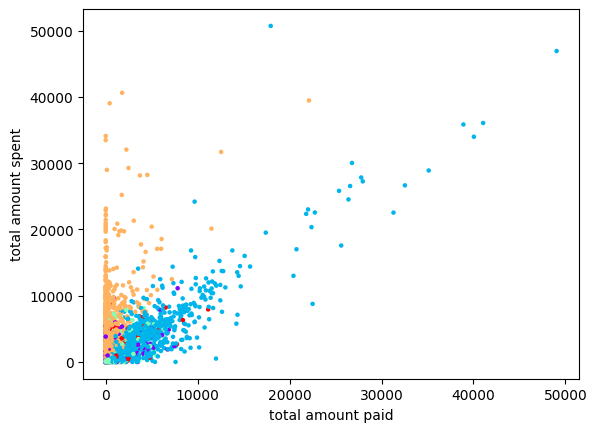

In [22]:
# 'labels' comes from clustering
# 's'
plt.scatter(df['PURCHASES'], df['PAYMENTS'], c=labels, s=5, cmap='rainbow' )
plt.xlabel("total amount paid")
plt.ylabel("total amount spent")
plt.show()

Two major clusters were generated with two predominant colors, purple and orange.

When we analyze the <font color='Orange'>orange cluster</font>, we notice that there is a tendency to draw a straight vertical line, which indicates that the total amount spent by customers is increasing, but the total amount paid does not follow this upward trend.

In general, what we can see is that the cluster represents customers who spent more, but didn't pay the bill or paid it partially.

The <font color='Purple'> purple cluster</font> shows a diagonal, which indicates that as the amount spent increases, so does the amount paid. This cluster represents customers who have paid their bill or almost paid it in full.

We have some interesting information, but that's not enough to understand the whole picture. We'll plot other dimensions, but always in pairs, so that we can interpret other attributes in a clear, visible way.

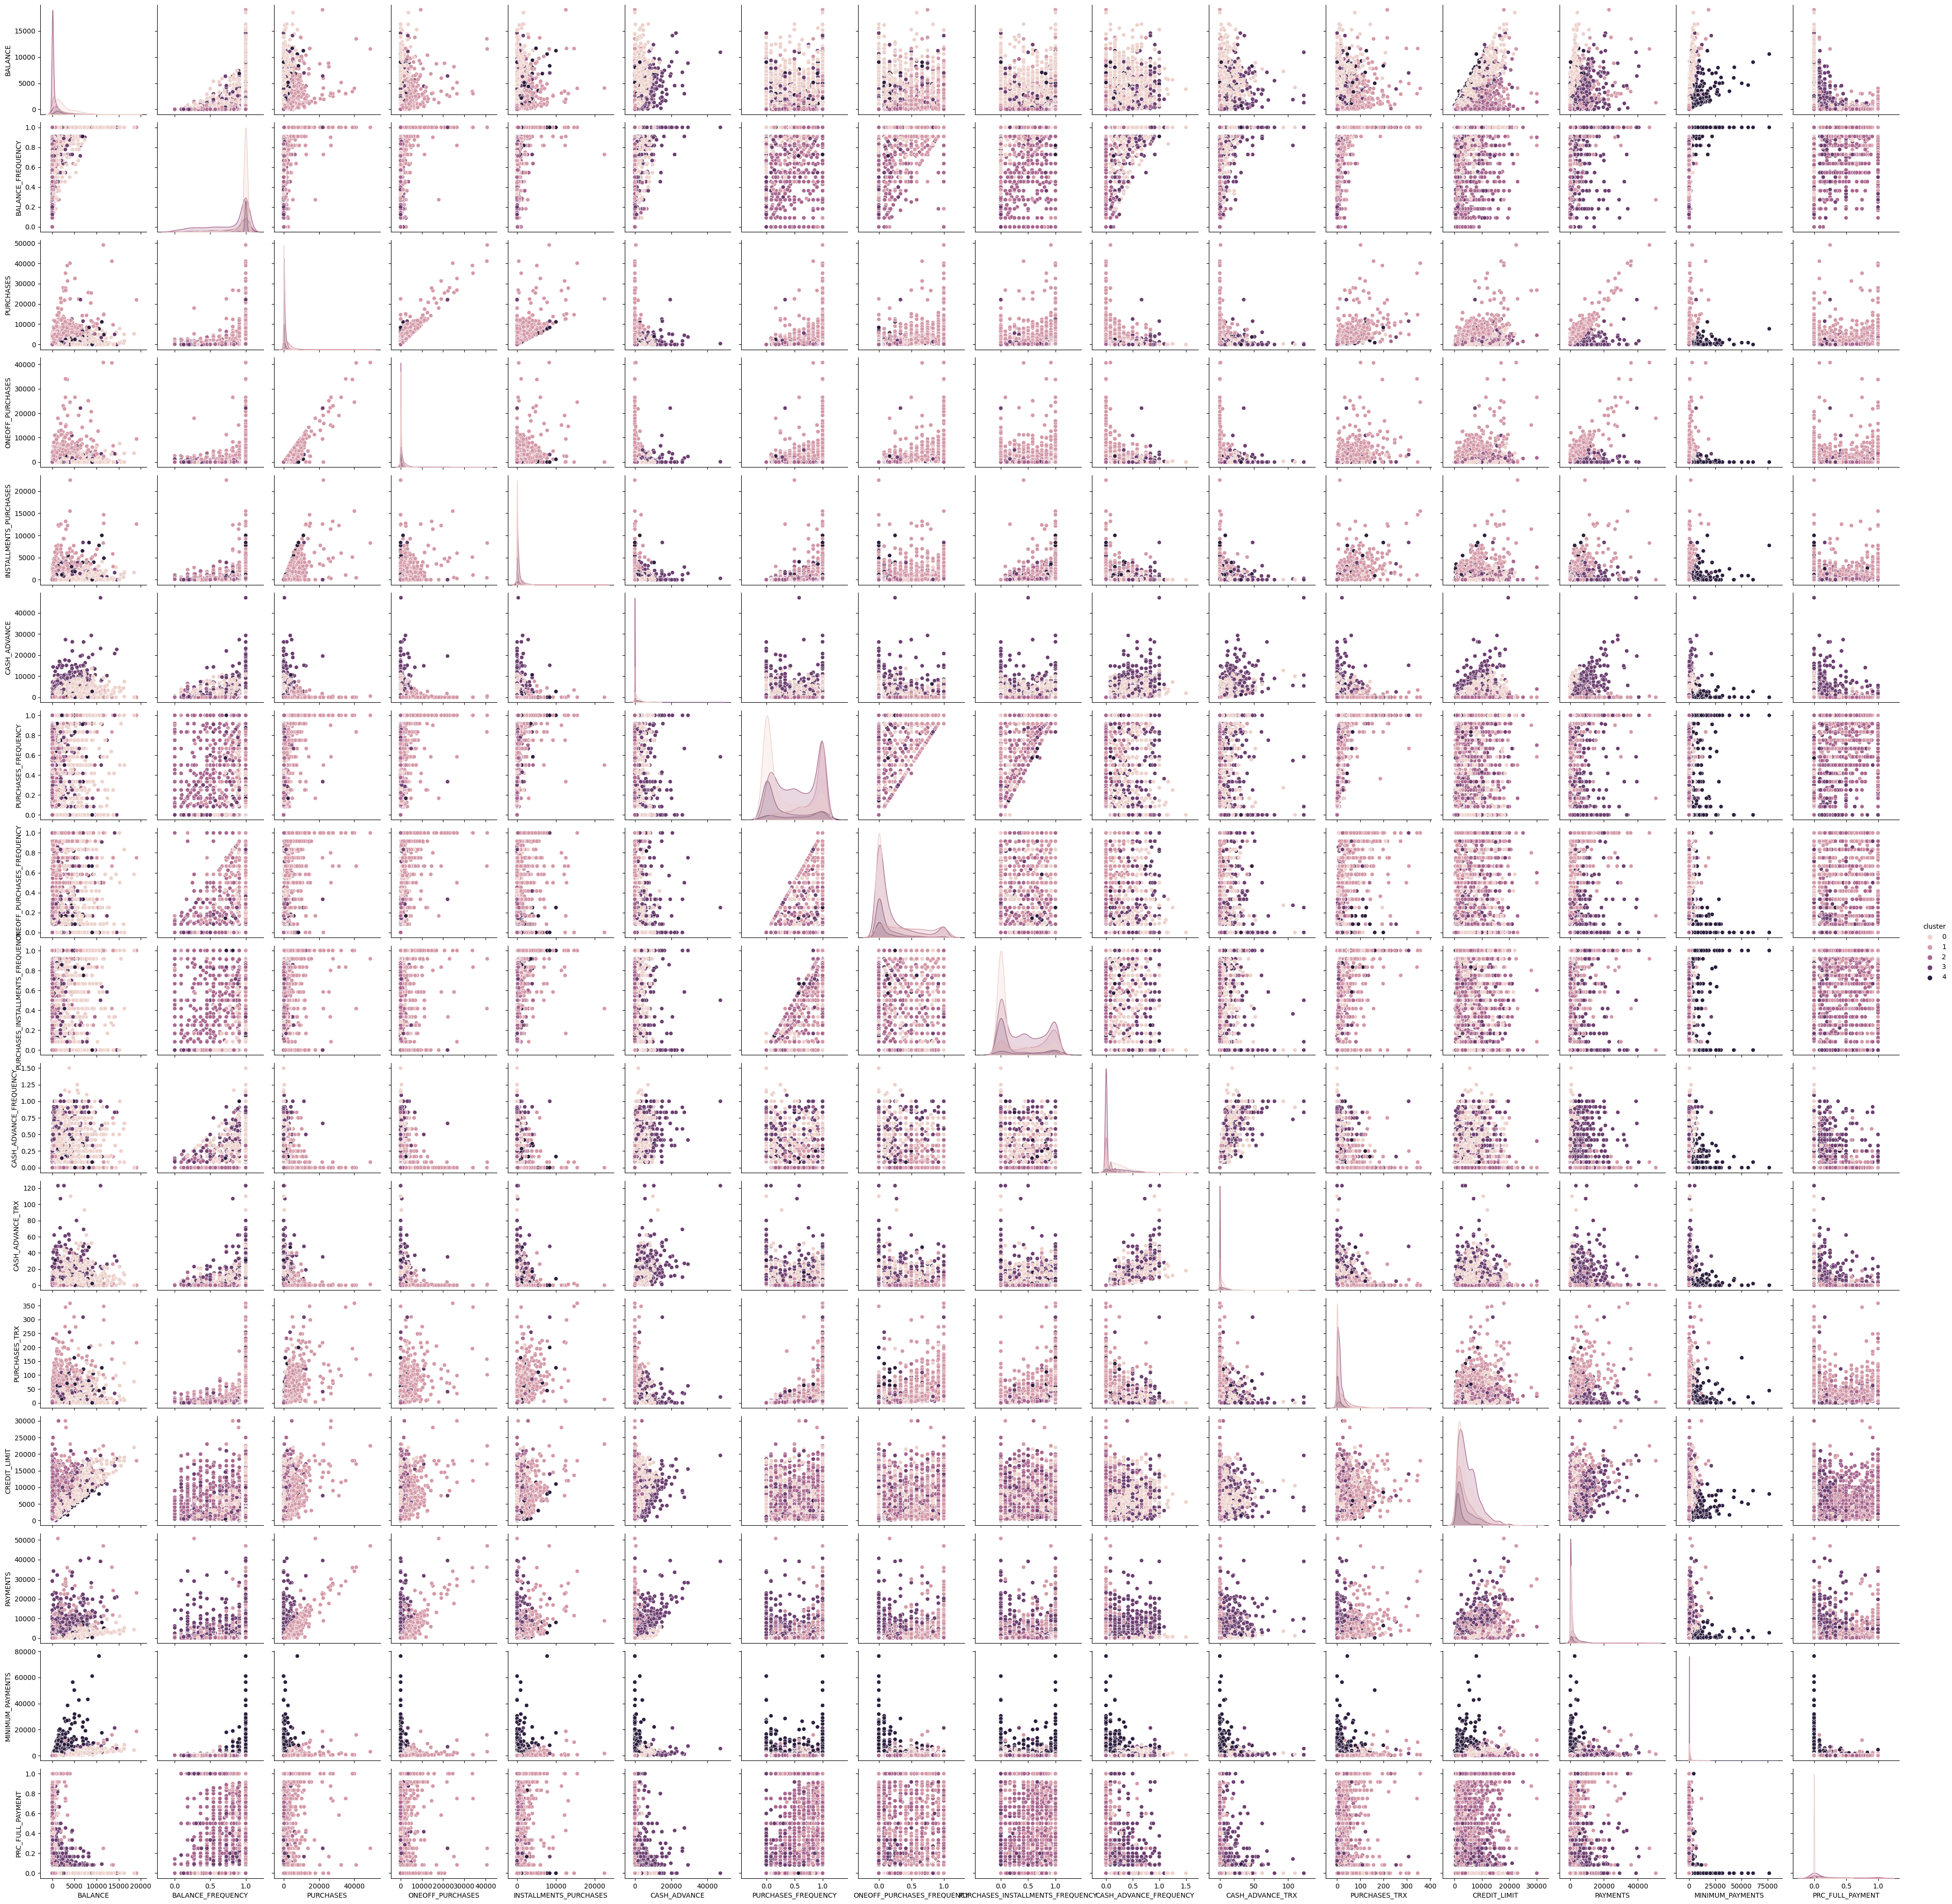

In [23]:
df["cluster"] = labels
sns.pairplot(df[0:], hue="cluster")

## Describing the variables

There are many attributes to analyze, so we will select some of the most significant ones. That's not to say that the others aren't important, but we'll need to do this sorting in order to carry out the analysis.

In [24]:
df.groupby("cluster").describe()

BALANCE                                                    \
          count         mean          std        min          25%   
cluster                                                             
0        2651.0  3036.509818  2478.358491   6.824905  1257.895616   
1        1537.0  1142.320861  1664.363459   0.000000   212.282538   
2        3280.0   443.746756   846.398201   0.000000    23.365333   
3        1074.0  1796.066730  1981.709522   0.000000   507.348768   
4         408.0  1990.318603  1860.968409  70.794108  1016.567882   

                                                BALANCE_FREQUENCY            \
                 50%          75%           max             count      mean   
cluster                                                                       
0        2171.222526  4223.849965  18495.558550            2651.0  0.963809   
1         555.131027  1370.317105  19043.138560            1537.0  0.928267   
2          82.941478   410.126095   9630.367575            3280.0  0.774389   
3        1092.020518  2319.052556  14581.459140            1074.0  0.862285   
4        1326.681742  2149.639085  11670.179850             408.0  0.989409   

         ... MINIMUM_PAYMENTS               PRC_FULL_PAYMENT            \
         ...              75%           max            count      mean   
cluster  ...                                                             
0        ...      1330.279644   8345.641905           2651.0  0.001798   
1        ...       523.893953  18621.013310           1537.0  0.278150   
2        ...       248.733727   4483.503862           3280.0  0.246806   
3        ...       885.787665  21235.065300           1074.0  0.117321   
4        ...      7184.162991  76406.207520            408.0  0.019460   

                                                      
              std  min  25%       50%       75%  max  
cluster                                               
0        0.023251  0.0  0.0  0.000000  0.000000  0.6  
1        0.367086  0.0  0.0  0.083333  0.545455  1.0  
2        0.346748  0.0  0.0  0.000000  0.444444  1.0  
3        0.186720  0.0  0.0  0.083333  0.142857  1.0  
4        0.091220  0.0  0.0  0.000000  0.000000  1.0  

[5 rows x 128 columns]

In [25]:
df.groupby('cluster').agg(['count','mean'])

BALANCE              BALANCE_FREQUENCY           PURCHASES  \
          count         mean             count      mean     count   
cluster                                                              
0          2651  3036.509818              2651  0.963809      2651   
1          1537  1142.320861              1537  0.928267      1537   
2          3280   443.746756              3280  0.774389      3280   
3          1074  1796.066730              1074  0.862285      1074   
4           408  1990.318603               408  0.989409       408   

                     ONEOFF_PURCHASES              INSTALLMENTS_PURCHASES  \
                mean            count         mean                  count   
cluster                                                                     
0         385.376134             2651   233.314104                   2651   
1        3273.425517             1537  2127.977619                   1537   
2         629.249107             3280   314.074954                   3280   
3         477.099721             1074   287.199255                   1074   
4         856.504755              408   182.547377                    408   

                      ... PURCHASES_TRX            CREDIT_LIMIT               \
                mean  ...         count       mean        count         mean   
cluster               ...                                                      
0         152.151215  ...          2651   7.192003         2651  4493.115805   
1        1146.065335  ...          1537  37.910865         1537  4097.306540   
2         315.509040  ...          3280  11.953049         3280  5130.547795   
3         189.953277  ...          1074   7.379888         1074  3981.537441   
4         674.805539  ...           408  17.612745          408  2231.985294   

        PAYMENTS              MINIMUM_PAYMENTS              PRC_FULL_PAYMENT  \
           count         mean            count         mean            count   
cluster                                                                        
0           2651   968.393476             2651  1022.033283             2651   
1           1537  3036.763695             1537   542.337644             1537   
2           3280   814.294226             3280   228.519011             3280   
3           1074  4710.615663             1074   735.131527             1074   
4            408  1340.280120              408  6078.085177              408   

                   
             mean  
cluster            
0        0.001798  
1        0.278150  
2        0.246806  
3        0.117321  
4        0.019460  

[5 rows x 32 columns]

## Analyzing the values

<font color='RoyalBlue'>Strategy for selecting the most significant attribute and analyzing it:</font>

We have the value of each of the 16 attributes of the 5 clusters. We will observe the variance of the centroids for a given attribute, i.e. we will collect an attribute and check how it behaves in the different clusters.

For example, if we take the first cluster with a value of 1.59699490e-01 for the first "BALANCE" attribute.

The next cluster will already be very different, and the same goes for the following ones.

Since we're going to analyze variance, we'll look for an attribute where the values are different between the clusters, so that we have a better chance of observing the particularities of each group.

For example, we can see that we have customers who spend a lot in one cluster and those who spend little in another. However, there may be some other attribute where the difference isn't significant and won't help or even hinder our interpretation.

So we'll use the variance calculation. <font color='RoyalBlue'>Those attributes with the greatest variance will be used.</font>

In [26]:
# selects the KMeans centroids of each of the clusters
centroids = kmeans.cluster_centers_
centroids

array([[5.04526580e-01, 2.72332745e-04, 6.20171708e-02, 3.64414607e-02,
        2.55974069e-02, 2.52329514e-01, 6.75600478e-05, 2.58663568e-05,
        4.51550497e-05, 5.73437494e-05, 1.15422756e-03, 1.33589087e-03,
        7.18989200e-01, 1.66362861e-01, 1.79601509e-01, 5.51886878e-07],
       [1.60217275e-01, 2.45258545e-04, 4.38567850e-01, 2.57141814e-01,
        1.81597658e-01, 2.58559897e-02, 2.04371792e-04, 8.90426987e-05,
        1.50570655e-04, 9.38731157e-06, 1.69791390e-04, 6.17288930e-03,
        6.03681606e-01, 4.02502783e-01, 8.56498262e-02, 7.18989321e-05],
       [6.91003939e-02, 2.30735820e-04, 1.21488582e-01, 4.79706676e-02,
        7.36181130e-02, 2.44793374e-02, 1.72814707e-04, 3.36627014e-05,
        1.40285541e-04, 7.93816793e-06, 1.25005935e-04, 2.86309441e-03,
        9.43533996e-01, 1.53766191e-01, 5.68572256e-02, 7.61261275e-05],
       [2.35306625e-01, 2.16352812e-04, 6.05163989e-02, 3.44248410e-02,
        2.60967627e-02, 3.99956952e-01, 5.27259778e-05, 2.050

## Selecting variables

We will select the variables with the highest variance, i.e. those with a significant difference between the clusters. The most relevant ones will be used for the detailed analysis of the clusters.

In [29]:
# variance of each variable
max = len(centroids[0])
for i in range(max):
    print(df.columns.values[i],"{:.4f}".format(centroids[:, i].var()))  # "\n{:.4f}"

BALANCE 0.0223
BALANCE_FREQUENCY 0.0000
PURCHASES 0.0197
ONEOFF_PURCHASES 0.0077
INSTALLMENTS_PURCHASES 0.0036
CASH_ADVANCE 0.0225
PURCHASES_FREQUENCY 0.0000
ONEOFF_PURCHASES_FREQUENCY 0.0000
PURCHASES_INSTALLMENTS_FREQUENCY 0.0000
CASH_ADVANCE_FREQUENCY 0.0000
CASH_ADVANCE_TRX 0.0000
PURCHASES_TRX 0.0000
CREDIT_LIMIT 0.0362
PAYMENTS 0.0279
MINIMUM_PAYMENTS 0.0549
PRC_FULL_PAYMENT 0.0000


In [45]:
max = len(centroids[0])

col_list = []
var_list = []

for i in range(max):
    col_list.append(df.columns.values[i])
    var_list.append(round(centroids[:, i].var(), 4))

In [53]:
df_var = pd.DataFrame(
    {
        'variable': col_list,
        'variance': var_list
    }
)

df_var.sort_values(by=['variance'], ascending=False).query('variance > 0.01')

variable  variance
14  MINIMUM_PAYMENTS    0.0549
12      CREDIT_LIMIT    0.0362
13          PAYMENTS    0.0279
5       CASH_ADVANCE    0.0225
0            BALANCE    0.0223
2          PURCHASES    0.0197

* MINIMUM_PAYMENTS - minimum paid (less relevant)
* CREDIT_LIMIT - total credit limit
* PAYMENTS - total amount paid
* CASH_ADVANCE - total value of withdrawals
* BALANCE - client limit available
* PURCHASES - total value of purchases



## Filtering the values

In [54]:
df.groupby("cluster")["BALANCE"].describe()

count         mean          std        min          25%  \
cluster                                                             
0        2651.0  3036.509818  2478.358491   6.824905  1257.895616   
1        1537.0  1142.320861  1664.363459   0.000000   212.282538   
2        3280.0   443.746756   846.398201   0.000000    23.365333   
3        1074.0  1796.066730  1981.709522   0.000000   507.348768   
4         408.0  1990.318603  1860.968409  70.794108  1016.567882   

                 50%          75%           max  
cluster                                          
0        2171.222526  4223.849965  18495.558550  
1         555.131027  1370.317105  19043.138560  
2          82.941478   410.126095   9630.367575  
3        1092.020518  2319.052556  14581.459140  
4        1326.681742  2149.639085  11670.179850

In [59]:
description = df.groupby("cluster")[["BALANCE", "PURCHASES", "CASH_ADVANCE", "CREDIT_LIMIT", "PAYMENTS"]]
n_clients = description.size()
description = description.mean()
description['n_clients'] = n_clients
description

BALANCE    PURCHASES  CASH_ADVANCE  CREDIT_LIMIT     PAYMENTS  \
cluster                                                                      
0        3036.509818   385.376134   1634.262935   4493.115805   968.393476   
1        1142.320861  3273.425517    183.376625   4097.306540  3036.763695   
2         443.746756   629.249107    141.482978   5130.547795   814.294226   
3        1796.066730   477.099721   3267.660346   3981.537441  4710.615663   
4        1990.318603   856.504755    424.225892   2231.985294  1340.280120   

         n_clients  
cluster             
0             2651  
1             1537  
2             3280  
3             1074  
4              408

In [58]:
# another way
df.groupby('cluster')[["BALANCE", "PURCHASES", "CASH_ADVANCE", "CREDIT_LIMIT", "PAYMENTS"]].agg(['count','mean'])

BALANCE              PURCHASES              CASH_ADVANCE               \
          count         mean     count         mean        count         mean   
cluster                                                                         
0          2651  3036.509818      2651   385.376134         2651  1634.262935   
1          1537  1142.320861      1537  3273.425517         1537   183.376625   
2          3280   443.746756      3280   629.249107         3280   141.482978   
3          1074  1796.066730      1074   477.099721         1074  3267.660346   
4           408  1990.318603       408   856.504755          408   424.225892   

        CREDIT_LIMIT              PAYMENTS               
               count         mean    count         mean  
cluster                                                  
0               2651  4493.115805     2651   968.393476  
1               1537  4097.306540     1537  3036.763695  
2               3280  5130.547795     3280   814.294226  
3               1074  3981.537441     1074  4710.615663  
4                408  2231.985294      408  1340.280120